# Appendix: Code and supportive graphs

In [1]:
# #install netcdf4
# conda install -c conda-forge netcdf4

# Import existing code modules
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import cm
from scipy import stats
from scipy.stats import norm
from scipy import signal

import netCDF4
import os
import glob
import math
import time

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from tqdm import trange
from sklearn.linear_model import LinearRegression
import warnings

In [537]:
# Set the input and output directories.
input_directory='/Users/mellie/Documents/EXE_ADSS/9  Project  60 credits/2022/'
output_directory = 'Outputs/'

filenames = sorted(glob.glob(os.path.join(input_directory,'*.nc')))
nfiles = len(filenames)
print('Number of files found: ', nfiles)

Number of files found:  162


# Exploratory Data Analysis

## 1. Non spatio-temporal patterns

In [3]:
mask = netCDF4.Dataset(filenames[0])

def landsea_array(nest = 77):
    coast = np.array(mask.variables['field'])[:, :, (nest-1)]
    return coast

def wind_speed(nest = 77):
    # Look at one file
    u = netCDF4.Dataset(filenames[nest])
    v = netCDF4.Dataset(filenames[nest+80])
    
    # Access the field variable
    u_series = np.array(u.variables['field'])
    v_series = np.array(v.variables['field'])[:, :, 0:512]
    speed = np.sqrt(u_series**2 + v_series**2)
    return speed

def wind_direction(nest = 77, x=0, y=0):
    # Access the field variable
    u_series = np.array(u.variables['field'])
    v_series = np.array(v.variables['field'])[:, :, 0:512]
    direction = (270-np.rad2deg(np.arctan2(v_series,u_series)))%360
    return direction

# Calculate the wind direction
# https://github.com/blaylockbk/Ute_WRF/blob/master/functions/wind_calcs.py
# wind["direction"] = (270-np.rad2deg(np.arctan2(wind["v"],wind["u"])))%360

In [302]:
# Nest 77 = the first time series
def plot_freq_dist(nest=77):
    time_series = wind_speed(nest=nest)
    mask_77 = landsea_array(nest = nest)

    land_speed = time_series*mask_77
    sea_speed = time_series*(1-mask_77)

    land_speed_add1 = (time_series+1)*mask_77
    sea_speed_add1 = (time_series+1)*(1-mask_77)

    # Flatten the land_speed array
    land_speed_flatten_add1 = land_speed_add1.flatten()
    sea_speed_flatten_add1 = sea_speed_add1.flatten()

    # Retrieve the original series
    land_speed_flatten = land_speed_flatten_add1[np.nonzero(land_speed_flatten_add1)] -1
    sea_speed_flatten = sea_speed_flatten_add1[np.nonzero(sea_speed_flatten_add1)] -1

    # Plot the histogram
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].hist(land_speed_flatten, bins=60, alpha=0.6, label='land')
    axs[0].hist(sea_speed_flatten, bins=60, alpha=0.6, label='sea')
    axs[0].legend()
    axs[0].set_title('Distribution of speed')

    sm.qqplot(land_speed_flatten, line='s', ax=axs[1])
    axs[1].set_title('QQ Plot - Land wind speed')

    sm.qqplot(sea_speed_flatten, line='s', ax=axs[2])
    axs[2].set_title('QQ Plot - Sea wind speed')

    plt.show()

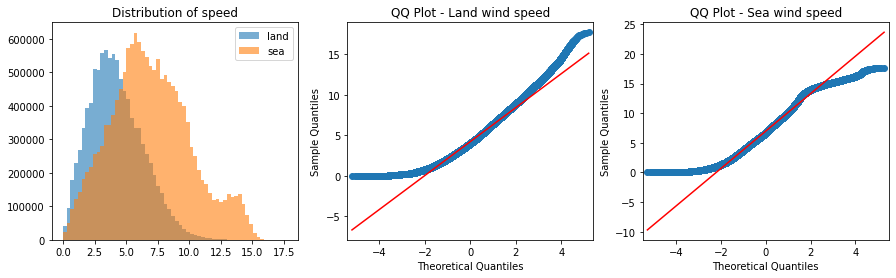

In [305]:
plot_freq_dist(nest=77)

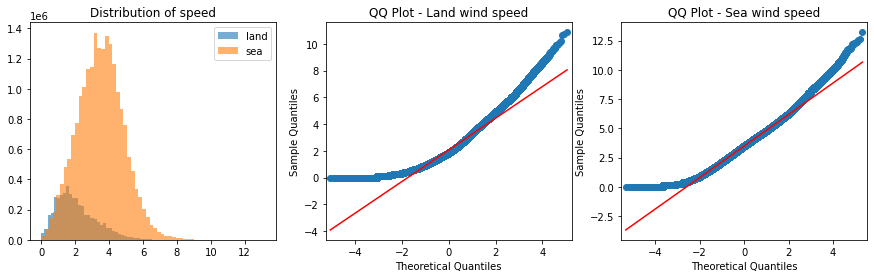

In [411]:
plot_freq_dist(nest=45)

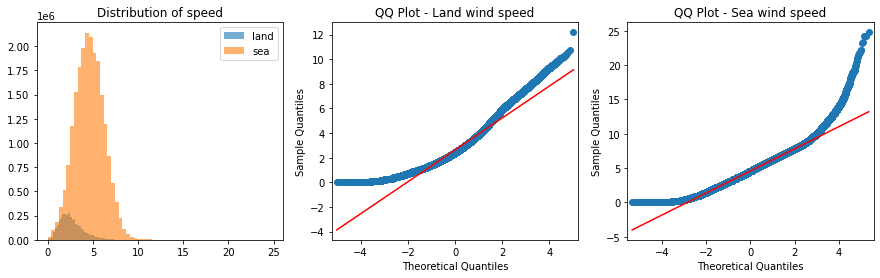

In [304]:
plot_freq_dist(nest=54)

## 2. Temporal Patterns

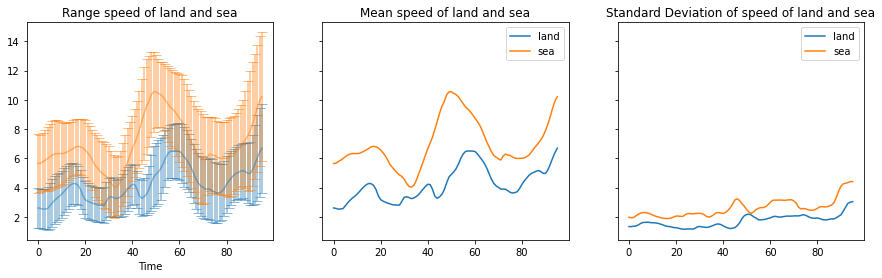

In [5]:
# Construct mean across grid
land_speed_mean_ts = np.sum(land_speed, axis = (1,2))/np.sum(mask_77)
sea_speed_mean_ts = np.sum(sea_speed, axis = (1,2))/np.sum(1-mask_77)

# Construct var across grid
land_speed_var_ts = np.sum((land_speed - land_speed_mean_ts[:, np.newaxis, np.newaxis]*mask_77)**2, axis = (1,2))/np.sum(mask_77)
sea_speed_var_ts = np.sum((sea_speed - sea_speed_mean_ts[:, np.newaxis, np.newaxis]*(1-mask_77))**2, axis = (1,2))/np.sum(1-mask_77)

# Construct standard deviation across grid
land_speed_std_ts = np.sqrt(land_speed_var_ts)
sea_speed_std_ts = np.sqrt(sea_speed_var_ts)

# Plot mean and deviation
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axs[0].errorbar(range(len(land_speed_mean_ts)), land_speed_mean_ts, 
             yerr=land_speed_std_ts,
             fmt='-', markersize=5, capsize=5, alpha = 0.5)
axs[0].errorbar(range(len(sea_speed_mean_ts)), sea_speed_mean_ts, 
             yerr=sea_speed_std_ts,
             fmt='-', markersize=5, capsize=5, alpha = 0.5)
axs[0].set_title('Range speed of land and sea')
axs[0].set_xlabel('Time')

axs[1].plot(land_speed_mean_ts,label='land')
axs[1].plot(sea_speed_mean_ts,label='sea')
axs[1].set_title('Mean speed of land and sea')
axs[1].legend()

axs[2].plot(land_speed_std_ts,label='land')
axs[2].plot(sea_speed_std_ts,label='sea')
axs[2].set_title('Standard Deviation of speed of land and sea')
axs[2].legend()

plt.show()

# Fourier series at some locations

In [6]:
def plot_coastline(nest = 77):
    coast = np.array(mask.variables['field'])[:, :, (nest-1)]
    
    # Create coordinate arrays for x and y
    x = np.arange(coast.shape[0])
    y = np.arange(coast.shape[1])
    
    # Plot the data
    plt.imshow(np.transpose(coast), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='binary', alpha = 0.3)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of nest {nest}')
    plt.show()
    
def fourier_24_12(Y):
    X = pd.DataFrame()
    # Add a constant column for the intercept
    X['intercept'] = np.ones(Y.shape[0])
    X['index'] = np.arange(Y.shape[0])
    X['sinx24h'] = np.sin(2 * np.pi * X['index'] * 1 / 24)
    X['cosx24h'] = np.cos(2 * np.pi * X['index'] * 1 / 24)
    X['sinx12h'] = np.sin(2 * np.pi * X['index'] * 1 / 12)
    X['cosx12h'] = np.cos(2 * np.pi * X['index'] * 1 / 12)

    # Create the linear regression model
    reg = LinearRegression()
    reg.fit(X, Y)

    # Get the coefficients
    intercept = reg.intercept_
    coefficients = reg.coef_
    
    # Get the predicted values
    predicted_values = reg.predict(X)

    # Calculate the residuals
    residuals = Y - predicted_values
    
    result = np.concatenate(([intercept],coefficients[1:], residuals, predicted_values))

    return result

def plot_fourier_result(result_array, nest=77):
    # Create coordinate arrays for x and y
    x = np.arange(result_array.shape[1])
    y = np.arange(result_array.shape[2])

    # Coeff of cycle 24h
    coef_sin_24h = result_array[2, :, :]
    coef_cos_24h = result_array[3, :, :]
    coef_24h = np.sqrt(coef_sin_24h**2 + coef_cos_24h**2)

    # Coeff of cycle 12h
    coef_sin_12h = result_array[4, :, :]
    coef_cos_12h = result_array[5, :, :]
    coef_12h = np.sqrt(coef_sin_12h**2 + coef_cos_12h**2)

    # Residuals mean and std errors
    resid_mean = result_array[6:102, :, :]
    resid_mean_arr = np.mean(resid_mean, axis=0)
    resid_std_arr = np.std(resid_mean, axis=0)

    # Plot the location
    plot_coastline(nest = nest)

    # Plot model results 
    plt.imshow(np.transpose(result_array[1, :, :]), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of coefficient linear trend')
    plt.show()

    plt.imshow(np.transpose(coef_24h), vmin=0, vmax=3, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of coefficient cycle 24h')
    plt.show()

    plt.imshow(np.transpose(coef_12h), vmin=0, vmax=1.6, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of coefficient cycle 12h')
    plt.show()

    plt.imshow(np.transpose(resid_mean_arr), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of mean of residuals')
    plt.show()

    plt.imshow(np.transpose(resid_std_arr), vmin=0, vmax=4, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha = 0.7)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of standard error of residuals')
    plt.show()

    # Show the plot
    

In [ ]:
# Location 1: Ireland - GB
time_series = wind_speed(nest = 77)
result_array = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series)

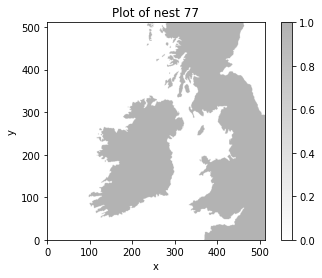

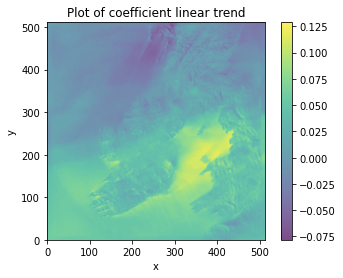

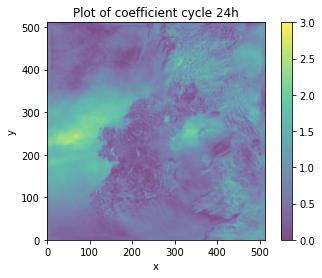

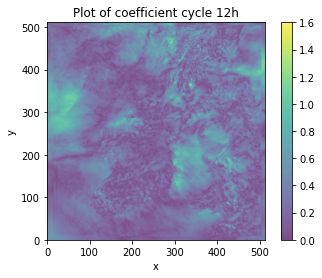

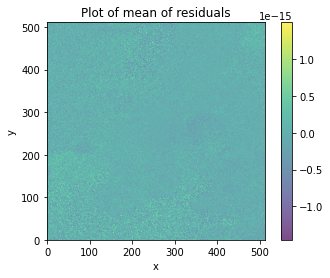

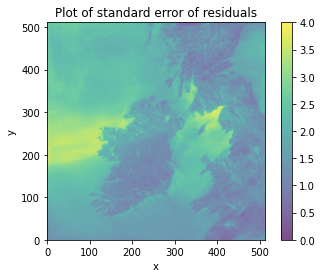

In [459]:
# Location 1: Ireland - GB
plot_fourier_result(result_array, nest=77)

In [ ]:
# Location 2: Phillipines
time_series2 = wind_speed(nest=45)
result_array2 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series2)

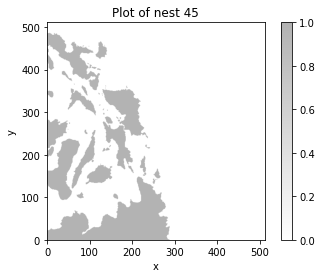

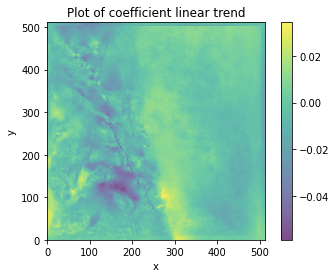

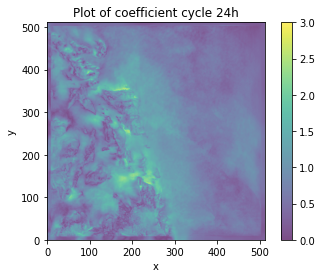

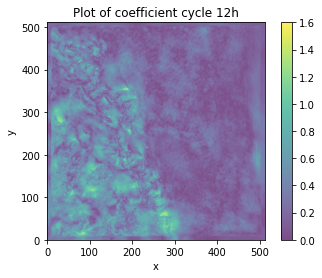

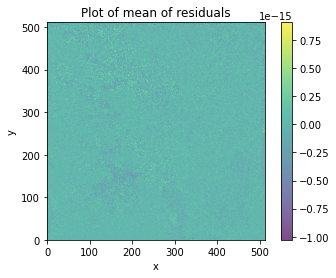

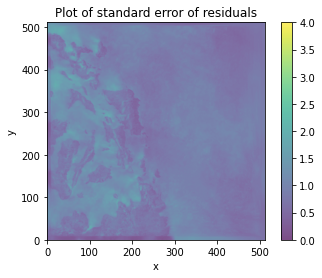

In [460]:
# Location 2: Phillipines
plot_fourier_result(result_array2, nest=45)

In [ ]:
# Location 3: Atlantic Ocean to the east of Gulf stream
time_series3 = wind_speed(nest=66)
result_array3 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series3)

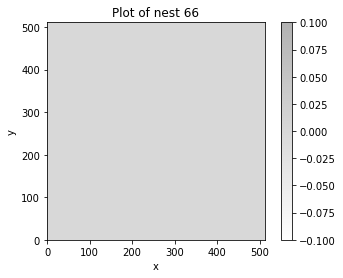

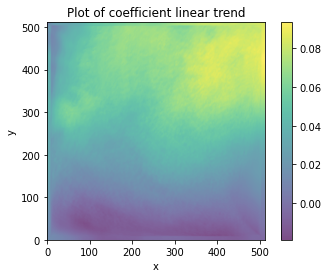

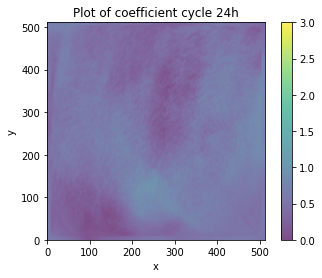

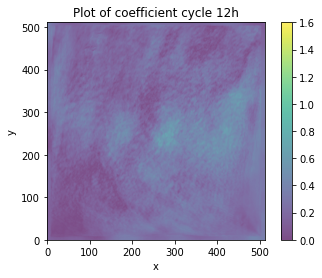

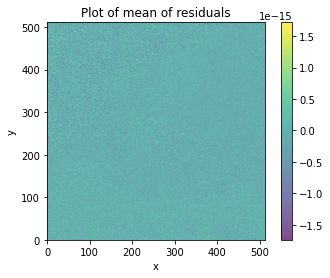

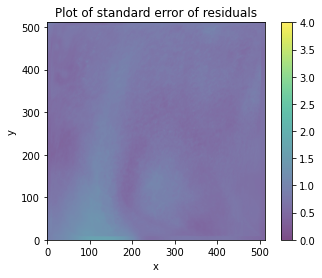

In [461]:
# Location 3: Atlantic Ocean to the east of Gulf stream
plot_fourier_result(result_array3, nest=66)

In [ ]:
# Location 4: ~ Atlanta coastal line
time_series4 = wind_speed(nest=65)
result_array4 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series4)

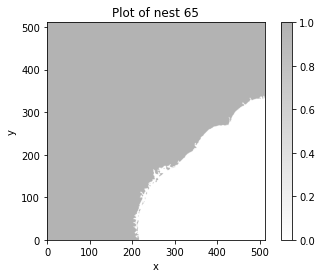

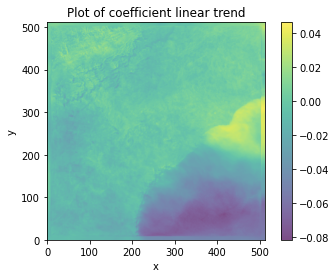

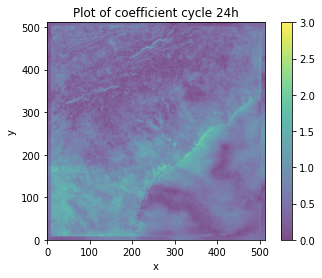

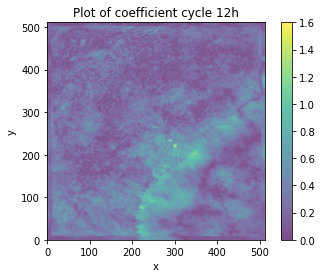

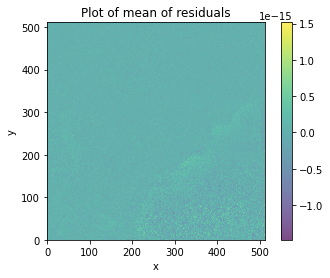

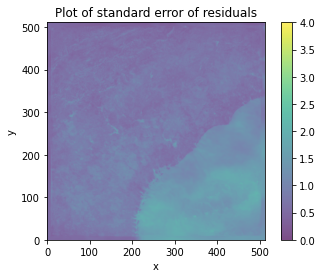

In [462]:
# Location 4: ~ Atlanta coastal line
plot_fourier_result(result_array4, nest=65)

In [ ]:
# Location 5: Sahel
time_series5 = wind_speed(nest=54)
result_array5 = np.apply_along_axis(fourier_24_12, axis=0, arr=time_series5)

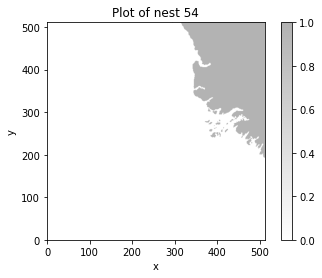

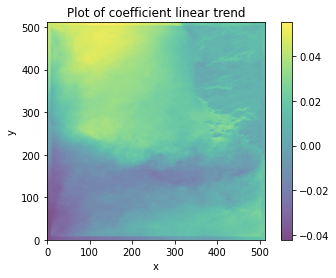

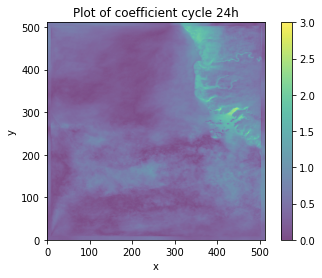

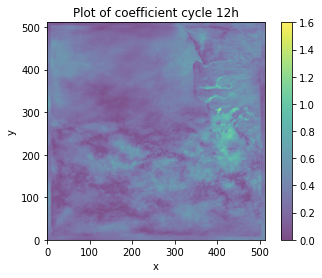

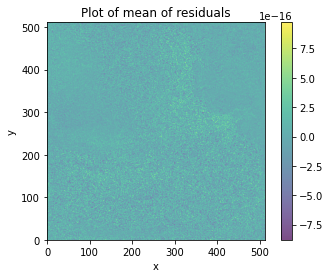

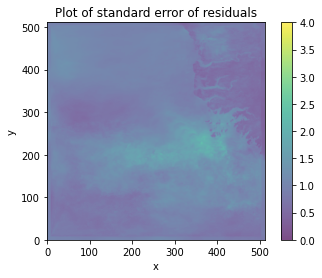

In [463]:
# Location 5: Sahel
plot_fourier_result(result_array5, nest=54)

# Residuals Analysis

In [400]:
# Compute the empirical CDF of the residues
def empirical_cdf(data, x, smoothing=1):
    n = len(data)
    return np.sum(data <= x) / (n + smoothing)

# Transform the residues into a normal dataset using equation (9)
def transform_to_normal(residues):
    transformed_data = norm.ppf([empirical_cdf(residues, r) for r in residues])
    return transformed_data

# Define AR(1) and transform the residuals
def AR1_residuals_params(residual):
    model = sm.tsa.arima.ARIMA(residual, order=(1, 0, 0))
    try:
        results_AR = model.fit(return_params=True, low_memory=True)
        return results_AR[1]
    except ValueError:
        return 0

In [451]:
import matplotlib.colors as mcolors

def plot_AR1_coef (residuals_model):
    x = np.arange(residuals_model.shape[0])
    y = np.arange(residuals_model.shape[1])
    
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', 
                                                     [(0, 'blue'),
                                                      (1, 'yellow')])

    
    plt.imshow(np.transpose(residuals_model), 
               extent=(x.min(), x.max(), y.min(), y.max()), 
               origin='lower', cmap=cmap, vmin=-0.2, vmax=1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of AR(1) term of residuals')
    plt.show()

In [405]:
# residuals from Ireland
resid = result_array[6:102, :, :]
normalised_resid = np.apply_along_axis(transform_to_normal, axis=0, arr=resid)

In [ ]:
# Ignore the ConvergenceWarning temporarily
# Compute AR(1) terms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    residuals_model = np.apply_along_axis(AR1_residuals_params, axis=0, arr=normalised_resid)

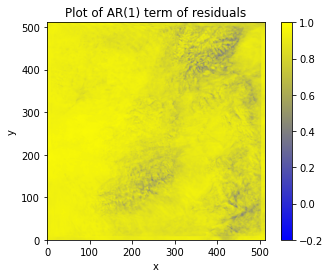

In [452]:
# plot AR(1) coeff across the Ireland
plot_AR1_coef (residuals_model)

In [416]:
# residuals from Philippines
resid2 = result_array2[6:102, :, :]
normalised_resid2 = np.apply_along_axis(transform_to_normal, axis=0, arr=resid2)

In [418]:
# Ignore the ConvergenceWarning temporarily
# Compute AR(1) terms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    residuals_model2 = np.apply_along_axis(AR1_residuals_params, axis=0, arr=normalised_resid2)

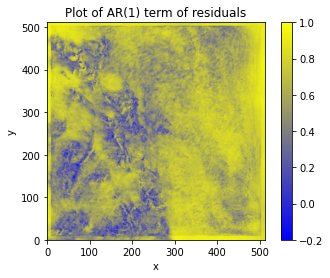

In [453]:
# plot AR(1) coeff across the Philippines
plot_AR1_coef (residuals_model2)

In [417]:
# residuals from Sahel
resid5 = result_array5[6:102, :, :]
normalised_resid5 = np.apply_along_axis(transform_to_normal, axis=0, arr=resid5)

In [425]:
# Ignore the ConvergenceWarning temporarily
# Compute AR(1) terms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    residuals_model5 = np.apply_along_axis(AR1_residuals_params, axis=0, arr=normalised_resid5)

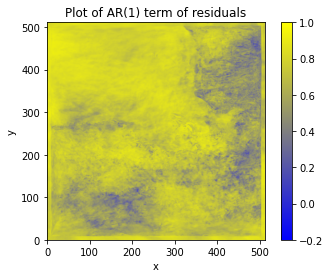

In [454]:
# plot AR(1) coeff across the Sahel
plot_AR1_coef (residuals_model5)

## Coastline and Distance from coastline
Compute the relationship between coefs and distance from coastline

In [464]:
def borderline(nest = 77):
    coast = np.array(mask.variables['field'])[:, :, (nest-1)]
    border1 = np.transpose(coast)

    border2 = np.hstack((border1, np.tile(border1[:, [-1]], 1)))
    border3 = np.hstack((np.tile(border1[:, [0]], 1), border1))
    
#     Draw borderline of both sides. 
#     All the 0s which are adjacent to 1s are flagged as borderline
    borderline_l = (border1 - border2[:,1:])
    borderline_r = (border1 - border3[:,:512])
#     Remove flag on land adjacent to sea 
    borderline_l[borderline_l == 1] = 0
    borderline_r[borderline_r == 1] = 0
#     Flag on sea adjacent to land
    borderline_l[borderline_l == 255] = 1
    borderline_r[borderline_r == 255] = 1
#     Merge both sides
    borderline = borderline_l + borderline_r
#     Replace the area between two land with flag 1
    borderline[borderline == 2] = 1
    return borderline
    

def plot_borderline(nest = 77):
    borderline_nest = borderline(nest = nest)
    
    # Create coordinate arrays for x and y
    x = np.arange(borderline_nest.shape[0])
    y = np.arange(borderline_nest.shape[1])
    
    # Plot the data
    plt.imshow(borderline_nest, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='binary')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Plot of nest {nest}')
    plt.show()
    
# # Check borderline
# # import plotly.express as px
# coast = np.array(mask.variables['field'])[:, :, (77-1)]
# coast = np.transpose(coast)
# # border77 = borderline(nest = 77)

# # Create some example data
# x = np.linspace(0,511, 512)
# y1 = coast[107][:]
# y2 = border77[107][:]

# # Create a Plotly figure
# fig = px.line(x=x, y=[y1, y2], labels={'x': 'x', 'y': 'y'}, title='Zoom in to check borderline')
# # fig.update_traces(line=dict(color='blue', width=2), name='full')
# # fig.update_traces(line=dict(color='red', width=2), name='border')
# fig.show()

In [496]:
# Coeff of cycle 24h of Ireland
n77_coef_sin_24h = result_array[2, :, :]
n77_coef_cos_24h = result_array[3, :, :]
n77_coef_24h = np.sqrt(n77_coef_sin_24h**2 + n77_coef_cos_24h**2)
n77_t_coef_24h = np.transpose(n77_coef_24h)

# Coeff of cycle 12h of Ireland
n77_coef_sin_12h = result_array[4, :, :]
n77_coef_cos_12h = result_array[5, :, :]
n77_coef_12h = np.sqrt(n77_coef_sin_12h**2 + n77_coef_cos_12h**2)
n77_t_coef_12h = np.transpose(n77_coef_12h)

# Std resid of Ireland
n77_resid = result_array[6:102, :, :]
n77_resid_std = np.std(n77_resid, axis=0)
n77_t_resid_std = np.transpose(n77_resid_std)

# AR(1) resid of Ireland
n77_AR1 = residuals_model
n77_t_AR1 = np.transpose(n77_AR1)

In [498]:
# Coeff of cycle 24h of Sahel
n54_coef_sin_24h = result_array5[2, :, :]
n54_coef_cos_24h = result_array5[3, :, :]
n54_coef_24h = np.sqrt(n54_coef_sin_24h**2 + n54_coef_cos_24h**2)
n54_t_coef_24h = np.transpose(n54_coef_24h)

# Coeff of cycle 12h of Sahel
n54_coef_sin_12h = result_array5[4, :, :]
n54_coef_cos_12h = result_array5[5, :, :]
n54_coef_12h = np.sqrt(n54_coef_sin_12h**2 + n54_coef_cos_12h**2)
n54_t_coef_12h = np.transpose(n54_coef_12h)

# Std resid of Sahel
n54_resid = result_array5[6:102, :, :]
n54_resid_std = np.std(n54_resid, axis=0)
n54_t_resid_std = np.transpose(n54_resid_std)

# AR(1) resid of Sahel
n54_AR1 = residuals_model5
n54_t_AR1 = np.transpose(n54_AR1)

In [499]:
# Coeff of cycle 24h of Philippines
n45_coef_sin_24h = result_array2[2, :, :]
n45_coef_cos_24h = result_array2[3, :, :]
n45_coef_24h = np.sqrt(n45_coef_sin_24h**2 + n45_coef_cos_24h**2)
n45_t_coef_24h = np.transpose(n45_coef_24h)

# Coeff of cycle 12h of Philippines
n45_coef_sin_12h = result_array2[4, :, :]
n45_coef_cos_12h = result_array2[5, :, :]
n45_coef_12h = np.sqrt(n45_coef_sin_12h**2 + n45_coef_cos_12h**2)
n45_t_coef_12h = np.transpose(n45_coef_12h)

# Std resid of Philippines
n45_resid = result_array2[6:102, :, :]
n45_resid_std = np.std(n45_resid, axis=0)
n45_t_resid_std = np.transpose(n45_resid_std)

# AR(1) resid of Philippines
n45_AR1 = residuals_model2
n45_t_AR1 = np.transpose(n45_AR1)

In [476]:
# Get the borderline array
border77 = borderline(nest = 77)
border54 = borderline(nest = 54)
border45 = borderline(nest = 45)

# Calculate distance from land and sea
coast77 = np.array(mask.variables['field'])[:, :, (77-1)]
coast54 = np.array(mask.variables['field'])[:, :, (54-1)]
coast45 = np.array(mask.variables['field'])[:, :, (45-1)]

t_coast77 = np.transpose(coast77)
t_coast54 = np.transpose(coast54)
t_coast45 = np.transpose(coast45)

dist_transform77_fr_land = distance_transform_edt(t_coast77 == 0)
dist_transform77_fr_sea = distance_transform_edt((1-t_coast77) == 0)

dist_transform54_fr_land = distance_transform_edt(t_coast54 == 0)
dist_transform54_fr_sea = distance_transform_edt((1-t_coast54) == 0)

dist_transform45_fr_land = distance_transform_edt(t_coast45 == 0)
dist_transform45_fr_sea = distance_transform_edt((1-t_coast45) == 0)

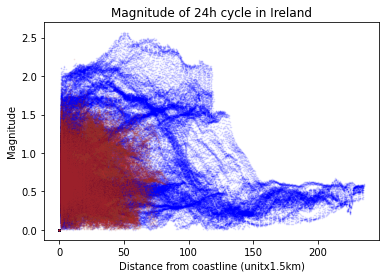

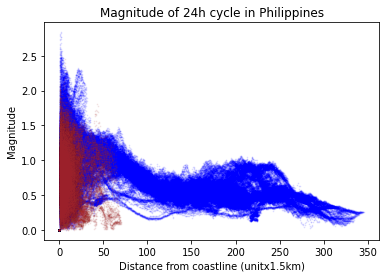

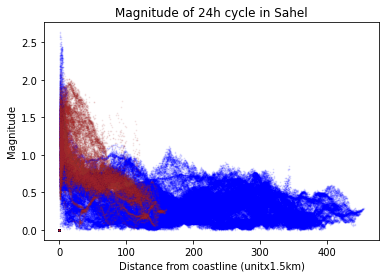

In [511]:
# coef 24h in Ireland
n77_t_coef_24h_land = n77_t_coef_24h*t_coast77
n77_t_coef_24h_sea = n77_t_coef_24h*(1-t_coast77)

# coef 24h in Sahel
n54_t_coef_24h_land = n54_t_coef_24h*t_coast54
n54_t_coef_24h_sea = n54_t_coef_24h*(1-t_coast54)

# coef 24h in Philippines
n45_t_coef_24h_land = n45_t_coef_24h*t_coast45
n45_t_coef_24h_sea = n45_t_coef_24h*(1-t_coast45)

# In Ireland
plt.scatter(dist_transform77_fr_land.flatten(), 
            n77_t_coef_24h_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform77_fr_sea.flatten(), 
            n77_t_coef_24h_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("Magnitude of 24h cycle in Ireland")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Magnitude")
plt.show()

# In Philippines
plt.scatter(dist_transform45_fr_land.flatten(), 
            n45_t_coef_24h_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform45_fr_sea.flatten(), 
            n45_t_coef_24h_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("Magnitude of 24h cycle in Philippines")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Magnitude")
plt.show()

# In Sahel
plt.scatter(dist_transform54_fr_land.flatten(), 
            n54_t_coef_24h_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform54_fr_sea.flatten(), 
            n54_t_coef_24h_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("Magnitude of 24h cycle in Sahel")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Magnitude")
plt.show()


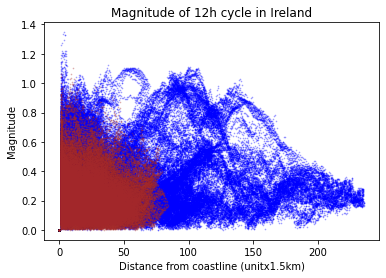

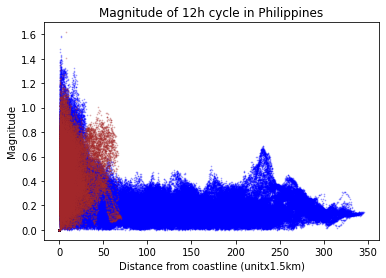

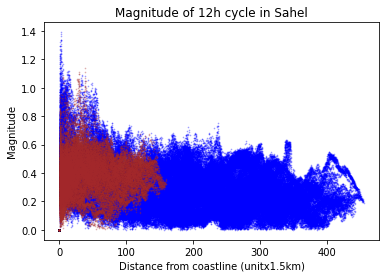

In [503]:
# coef 12h in Ireland
n77_t_coef_12h_land = n77_t_coef_12h*t_coast77
n77_t_coef_12h_sea = n77_t_coef_12h*(1-t_coast77)

# coef 12h in Sahel
n54_t_coef_12h_land = n54_t_coef_12h*t_coast54
n54_t_coef_12h_sea = n54_t_coef_12h*(1-t_coast54)

# coef 12h in Philippines
n45_t_coef_12h_land = n45_t_coef_12h*t_coast45
n45_t_coef_12h_sea = n45_t_coef_12h*(1-t_coast45)

# In Ireland
plt.scatter(dist_transform77_fr_land.flatten(), 
            n77_t_coef_12h_sea.flatten(), s=0.5, alpha=0.3, color='blue')
plt.scatter(dist_transform77_fr_sea.flatten(), 
            n77_t_coef_12h_land.flatten(), s=0.5, alpha=0.3, color='brown')
plt.title("Magnitude of 12h cycle in Ireland")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Magnitude")
plt.show()

# In Philippines
plt.scatter(dist_transform45_fr_land.flatten(), 
            n45_t_coef_12h_sea.flatten(), s=0.5, alpha=0.3, color='blue')
plt.scatter(dist_transform45_fr_sea.flatten(), 
            n45_t_coef_12h_land.flatten(), s=0.5, alpha=0.3, color='brown')
plt.title("Magnitude of 12h cycle in Philippines")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Magnitude")
plt.show()

# In Sahel
plt.scatter(dist_transform54_fr_land.flatten(), 
            n54_t_coef_12h_sea.flatten(), s=0.5, alpha=0.3, color='blue')
plt.scatter(dist_transform54_fr_sea.flatten(), 
            n54_t_coef_12h_land.flatten(), s=0.5, alpha=0.3, color='brown')
plt.title("Magnitude of 12h cycle in Sahel")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Magnitude")
plt.show()


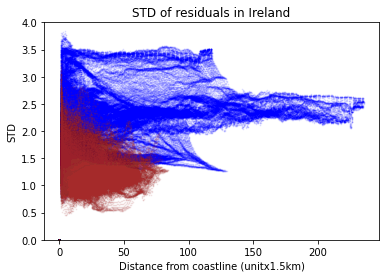

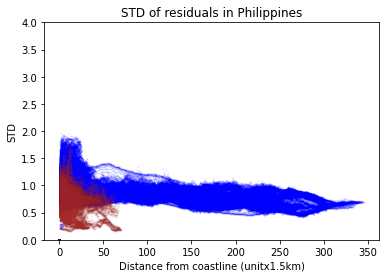

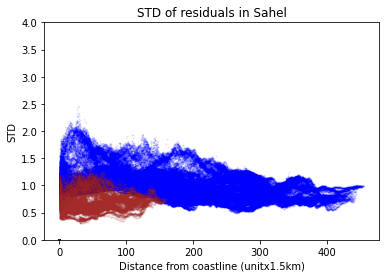

In [509]:
# STD of residuals in Ireland
n77_t_resid_std_land = n77_t_resid_std*t_coast77
n77_t_resid_std_sea = n77_t_resid_std*(1-t_coast77)

# STD of residuals in Sahel
n54_t_resid_std_land = n54_t_resid_std*t_coast54
n54_t_resid_std_sea = n54_t_resid_std*(1-t_coast54)

# STD of residuals in Philippines
n45_t_resid_std_land = n45_t_resid_std*t_coast45
n45_t_resid_std_sea = n45_t_resid_std*(1-t_coast45)

resid_std_ymin = 0
resid_std_ymax = 4

# In Ireland
plt.scatter(dist_transform77_fr_land.flatten(), 
            n77_t_resid_std_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform77_fr_sea.flatten(), 
            n77_t_resid_std_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("STD of residuals in Ireland")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("STD")
plt.ylim(resid_std_ymin, resid_std_ymax)
plt.show()

# In Philippines
plt.scatter(dist_transform45_fr_land.flatten(), 
            n45_t_resid_std_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform45_fr_sea.flatten(), 
            n45_t_resid_std_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("STD of residuals in Philippines")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("STD")
plt.ylim(resid_std_ymin, resid_std_ymax)
plt.show()

# In Sahel
plt.scatter(dist_transform54_fr_land.flatten(), 
            n54_t_resid_std_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform54_fr_sea.flatten(), 
            n54_t_resid_std_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("STD of residuals in Sahel")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("STD")
plt.ylim(resid_std_ymin, resid_std_ymax)
plt.show()


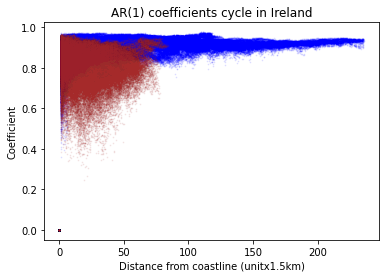

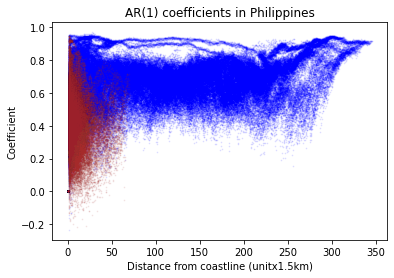

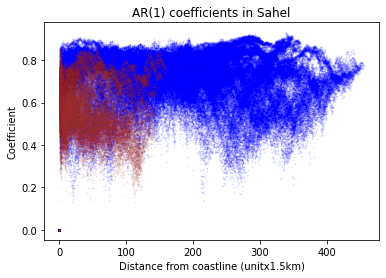

In [507]:
# AR(1) coefficients in Ireland
n77_t_AR1_land = n77_t_AR1*t_coast77
n77_t_AR1_sea = n77_t_AR1*(1-t_coast77)

# AR(1) coefficients in Sahel
n54_t_AR1_land = n54_t_AR1*t_coast54
n54_t_AR1_sea = n54_t_AR1*(1-t_coast54)

# AR(1) coefficients in Philippines
n45_t_AR1_land = n45_t_AR1*t_coast45
n45_t_AR1_sea = n45_t_AR1*(1-t_coast45)

# In Ireland
plt.scatter(dist_transform77_fr_land.flatten(), 
            n77_t_AR1_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform77_fr_sea.flatten(), 
            n77_t_AR1_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("AR(1) coefficients cycle in Ireland")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Coefficient")
plt.show()

# In Philippines
plt.scatter(dist_transform45_fr_land.flatten(), 
            n45_t_AR1_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform45_fr_sea.flatten(), 
            n45_t_AR1_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("AR(1) coefficients in Philippines")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Coefficient")
plt.show()

# In Sahel
plt.scatter(dist_transform54_fr_land.flatten(), 
            n54_t_AR1_sea.flatten(), s=0.5, alpha=0.1, color='blue')
plt.scatter(dist_transform54_fr_sea.flatten(), 
            n54_t_AR1_land.flatten(), s=0.5, alpha=0.1, color='brown')
plt.title("AR(1) coefficients in Sahel")
plt.xlabel("Distance from coastline (unitx1.5km)")
plt.ylabel("Coefficient")
plt.show()


In [517]:
# !pip install nbconvert[webpdf]
# !pip install pyppeteer

zsh:1: no matches found: nbconvert[webpdf]


In [520]:
# !jupyter nbconvert --to webpdf --allow-chromium-download MTHM504_wind_speed_land_sea_contrast.ipynb

[NbConvertApp] Converting notebook MTHM504_wind_speed_land_sea_contrast.ipynb to webpdf
[NbConvertApp] Building PDF
[INFO] Starting Chromium download.
100%|██████████████████████████████████████| 86.8M/86.8M [00:43<00:00, 2.01Mb/s]
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/mellie/Library/Application Support/pyppeteer/local-chromium/588429
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2441981 bytes to MTHM504_wind_speed_land_sea_contrast.pdf


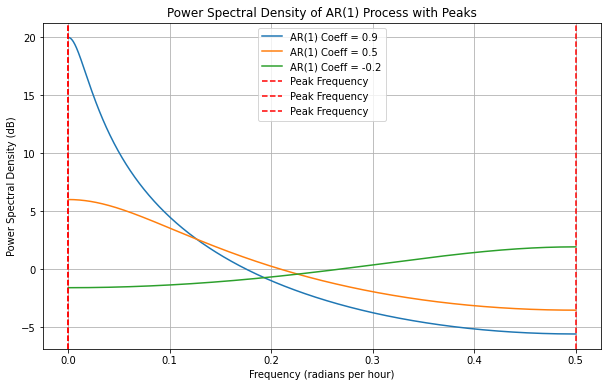

In [536]:
def ar1_psd(coeff, frequency_range):
    return 1 / np.abs(1 - coeff * np.exp(-2j * np.pi * frequency_range)) ** 2

# Parameters
coefficients = [0.9, 0.5, -0.2]
frequency_range = np.linspace(0, 0.5, 1000)  # Frequencies from 0 to 0.5 (Nyquist frequency)

# Calculate PSD for each coefficient
psds = [ar1_psd(coeff, frequency_range) for coeff in coefficients]

# Find the frequencies corresponding to the peaks
peak_frequencies = []
for psd in psds:
    peak_index = np.argmax(psd)  # Index of the peak in the PSD array
    peak_frequency = frequency_range[peak_index]  # Corresponding frequency value
    peak_frequencies.append(peak_frequency)

# Plot the PSDs
plt.figure(figsize=(10, 6))
for i, coeff in enumerate(coefficients):
    plt.plot(frequency_range, 10 * np.log10(psds[i]), label=f'AR(1) Coeff = {coeff}')

# Mark peaks with vertical lines
for frequency in peak_frequencies:
    plt.axvline(x=frequency, color='r', linestyle='--', label='Peak Frequency')

plt.xlabel('Frequency (radians per hour)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Power Spectral Density of AR(1) Process with Peaks')
plt.legend()
plt.grid()
plt.show()

In [556]:
lat = netCDF4.Dataset(filenames[161])
surface = np.array(lat.variables['ht'])